### **Load Path, Libraries, and Modules**

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correct path to scr
module_path = os.path.abspath(os.path.join("..", "scripts")) 

# Add path only if it exists
if module_path not in sys.path and os.path.exists(module_path):
    sys.path.append(module_path)

# Now import the data clearning module
from data_cleaning import load_raw_data, preprocess_data, save_interim

### **Raw Data Diagnostic**

In [2]:
# Load raw data
raw = load_raw_data('../data/row/MachineLearningRating_v3.txt')

# Preview
raw.head()

Loaded data with shape: (1000098, 52)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [3]:
# 🔹 Structural overview
print(f"The shape of raw data: {raw.shape}\n")

# 🔹 List all column names
print("Column names:")
for idx, key in enumerate(raw.columns.tolist()):
    print(f"{idx + 1}. {key}")

# 🔹 Count of data types
print("\nData type breakdown:")
print(raw.dtypes.value_counts())

The shape of raw data: (1000098, 52)

Column names:
1. UnderwrittenCoverID
2. PolicyID
3. TransactionMonth
4. IsVATRegistered
5. Citizenship
6. LegalType
7. Title
8. Language
9. Bank
10. AccountType
11. MaritalStatus
12. Gender
13. Country
14. Province
15. PostalCode
16. MainCrestaZone
17. SubCrestaZone
18. ItemType
19. mmcode
20. VehicleType
21. RegistrationYear
22. make
23. Model
24. Cylinders
25. cubiccapacity
26. kilowatts
27. bodytype
28. NumberOfDoors
29. VehicleIntroDate
30. CustomValueEstimate
31. AlarmImmobiliser
32. TrackingDevice
33. CapitalOutstanding
34. NewVehicle
35. WrittenOff
36. Rebuilt
37. Converted
38. CrossBorder
39. NumberOfVehiclesInFleet
40. SumInsured
41. TermFrequency
42. CalculatedPremiumPerTerm
43. ExcessSelected
44. CoverCategory
45. CoverType
46. CoverGroup
47. Section
48. Product
49. StatutoryClass
50. StatutoryRiskType
51. TotalPremium
52. TotalClaims

Data type breakdown:
object     36
float64    11
int64       4
bool        1
Name: count, dtype: int64


In [4]:
# Missing values
raw.isnull().mean().sort_values(ascending=False).head(10)

NumberOfVehiclesInFleet    1.000000
CrossBorder                0.999302
CustomValueEstimate        0.779566
Rebuilt                    0.641838
Converted                  0.641838
WrittenOff                 0.641838
NewVehicle                 0.153280
Bank                       0.145947
AccountType                0.040228
Gender                     0.009535
dtype: float64

In [5]:
# Cardinality
raw.nunique().sort_values(ascending=False).tail(10)

NewVehicle                 2
TrackingDevice             2
Converted                  2
ItemType                   1
Language                   1
Country                    1
StatutoryRiskType          1
CrossBorder                1
StatutoryClass             1
NumberOfVehiclesInFleet    0
dtype: int64

In [6]:
# Financial stats
raw[['TotalPremium', 'TotalClaims', 'CustomValueEstimate']].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalPremium,1000098.0,61.905496,230.284513,-782.576754,0.0,2.178333,21.929825,6.528260e+04
TotalClaims,1000098.0,64.861190,2384.074695,-12002.412281,0.0,0.000000,0.000000,3.930921e+05
CustomValueEstimate,220456.0,225531.129942,564515.749848,20000.000000,135000.0,220000.000000,280000.000000,2.655000e+07


---

#### 📌 What These Stats Are Whispering to Us

- **Negative Premiums and Claims?!** 🚨  
  Those negatives in `TotalPremium` and `TotalClaims` likely stem from data entry issues, cancellations, adjustments, or reversals. Flag these rows — they’ll mess with any aggregate metric and can’t be left unchecked.

- **TotalClaims is super sparse**  
  With the median and 75th percentile both at zero, this confirms what we suspected: most customers **don’t claim**, and a few go deep into the payout pool (hello, high max value).

- **CustomValueEstimate**  
  Even though it’s only non-null in ~22% of the data, it’s high in value and spread — meaning it could be a strong proxy for vehicle replacement cost or customer value *if* we model around its missingness properly.

---

<Axes: xlabel='TotalPremium', ylabel='Count'>

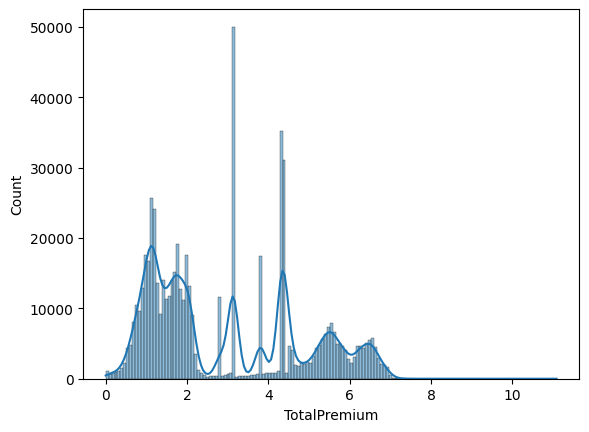

In [7]:
# Create flags for anomalies like negative values:
raw['HasNegativePremium'] = raw['TotalPremium'] < 0
raw['HasNegativeClaims'] = raw['TotalClaims'] < 0


sns.histplot(np.log1p(raw['TotalPremium'][raw['TotalPremium'] > 0]), kde=True)

In [8]:
# Categorical features stats
print('#'*40)
print(raw['Province'].value_counts())
print('#'*40)
print(raw['VehicleType'].value_counts())
print('#'*40)
print(raw['CoverType'].value_counts())

########################################
Province
Gauteng          393865
Western Cape     170796
KwaZulu-Natal    169781
North West       143287
Mpumalanga        52718
Eastern Cape      30336
Limpopo           24836
Free State         8099
Northern Cape      6380
Name: count, dtype: int64
########################################
VehicleType
Passenger Vehicle    933598
Medium Commercial     53985
Heavy Commercial       7401
Light Commercial       3897
Bus                     665
Name: count, dtype: int64
########################################
CoverType
Own Damage                                             104183
Passenger Liability                                    104158
Windscreen                                             103763
Third Party                                            102825
Keys and Alarms                                        102428
Signage and Vehicle Wraps                              102416
Emergency Charges                                      102416
Clea

### 🌍 **Province Distribution**
- **Gauteng dominates** (39% of total) — expect risk concentration here.
- **Western Cape & KwaZulu-Natal are secondary hubs**, with high insured populations.
- **Northern Cape & Free State have the lowest representation**, meaning regional segmentation could be key when analyzing risk.

---

### 🚗 **Vehicle Type Insights**
- **Passenger Vehicles make up an overwhelming majority (93%)**, followed by commercial types.
- **Commercial Vehicles (Medium, Heavy, Light)** may show different claim patterns due to higher exposure.
- **Bus coverage is rare (only 665 vehicles)**, possibly due to different insurance structures.

---

### 🔒 **CoverType Complexity**
- **Diverse insurance categories:** From Own Damage to Windscreens and Liability.
- **Top categories are core protections (Own Damage, Passenger Liability, Third Party).** This confirms the importance of policy customization.
- **Rare types like Factory Fitted Sound Equipment (only 3 policies)** suggest niche coverage offerings.
---

### **Data Cleaning and Store**

In [ ]:
clean = preprocess_data(raw)
clean.to_csv('../data/interim/cleaned_insurance_data.csv', index=False)

Remaining columns after cleaning: 51


c:\Users\girma\OneDrive\Desktop\10 Academy\week-3\insurance-risk-modeling\scripts\data_cleaning.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LossRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)


### 📊 **EDA Workflow on Cleaned Dataset**
#### **1️⃣ Data Summarization**
✅ **Descriptive Statistics** (Numerical variability):

In [10]:
clean[['TotalPremium', 'TotalClaims', 'CustomValueEstimate']].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalPremium,999810.0,61.954882,230.276131,0.0,0.0,2.179737,21.929825,6.528260e+04
TotalClaims,1000093.0,64.880169,2384.043041,0.0,0.0,0.000000,0.000000,3.930921e+05
CustomValueEstimate,999546.0,224845.049435,265721.653701,20000.0,220000.0,220000.000000,220000.000000,2.655000e+07


✅ **Data Structure & Formatting Validation**:

In [11]:
clean.info()  # Verify data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 51 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   UnderwrittenCoverID       1000098 non-null  int64         
 1   PolicyID                  1000098 non-null  int64         
 2   TransactionMonth          1000098 non-null  datetime64[ns]
 3   IsVATRegistered           1000098 non-null  bool          
 4   Citizenship               1000098 non-null  object        
 5   LegalType                 1000098 non-null  object        
 6   Title                     1000098 non-null  object        
 7   Bank                      854137 non-null   object        
 8   AccountType               959866 non-null   object        
 9   MaritalStatus             991839 non-null   object        
 10  Gender                    1000098 non-null  object        
 11  Province                  1000098 non-null  object

✅ **Missing Values Check**: 

In [12]:
clean.isna().sum().sort_values(ascending=False)

Rebuilt                     641901
WrittenOff                  641901
Converted                   641901
NewVehicle                  153295
Bank                        145961
AccountType                  40232
MaritalStatus                 8259
make                           552
mmcode                         552
VehicleType                    552
log_CustomValueEstimate        552
kilowatts                      552
cubiccapacity                  552
Cylinders                      552
Model                          552
bodytype                       552
NumberOfDoors                  552
VehicleIntroDate               552
CustomValueEstimate            552
LossRatio                      293
TotalPremium                   288
log_TotalPremium               288
log_TotalClaims                  5
TotalClaims                      5
CapitalOutstanding               2
Province                         0
SubCrestaZone                    0
IsVATRegistered                  0
Title               

### **2️⃣ Univariate Analysis**

✅ **Histogram for key numerical variables**:

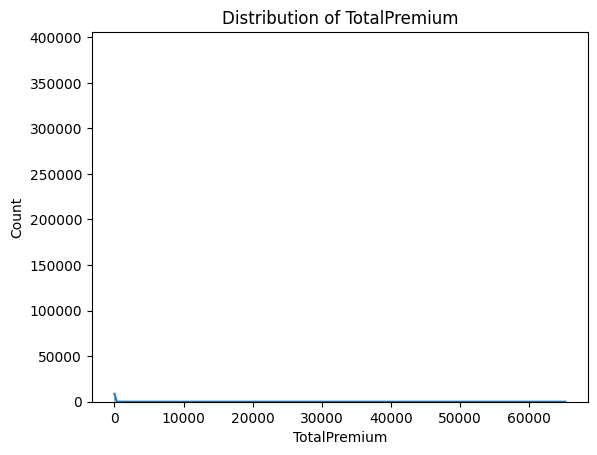

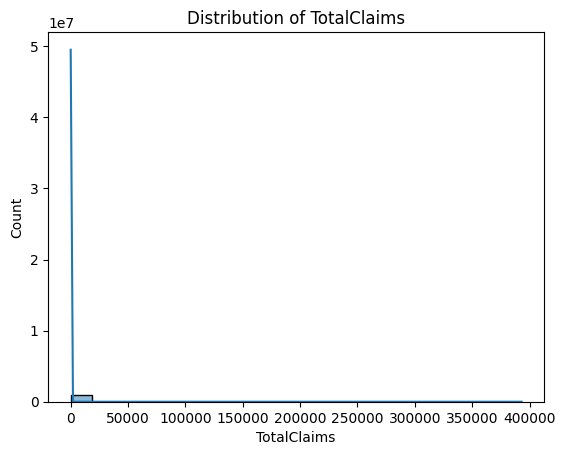

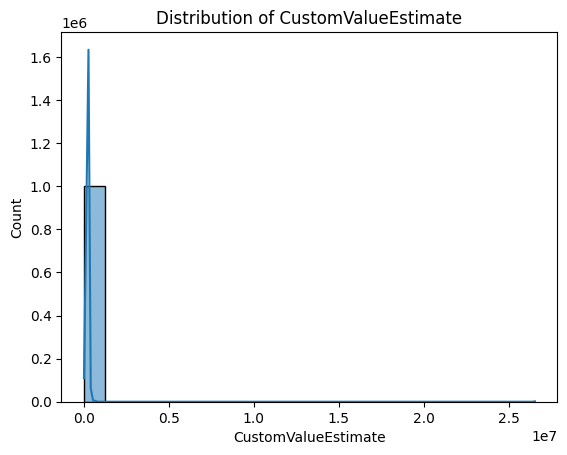

In [13]:
num_cols = ['TotalPremium', 'TotalClaims', 'CustomValueEstimate']
for col in num_cols:
    sns.histplot(clean[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

✅ **Bar chart for categorical variables**:

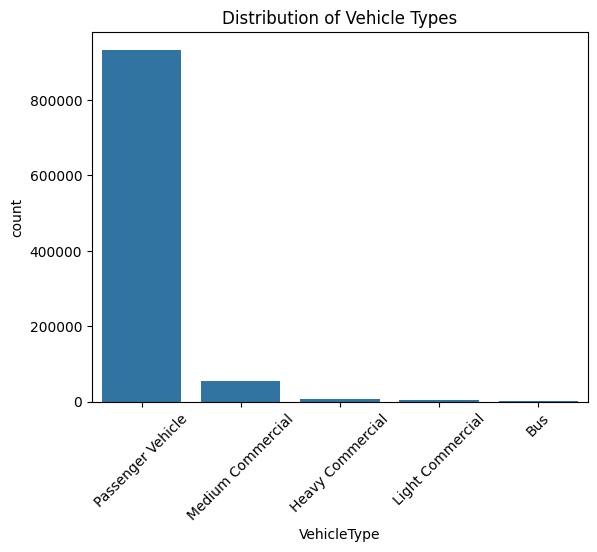

In [14]:
sns.countplot(x='VehicleType', data=clean)
plt.xticks(rotation=45)
plt.title('Distribution of Vehicle Types')
plt.show()

### **3️⃣ Bivariate & Multivariate Analysis**
✅ **Correlation Matrix for financial metrics**:

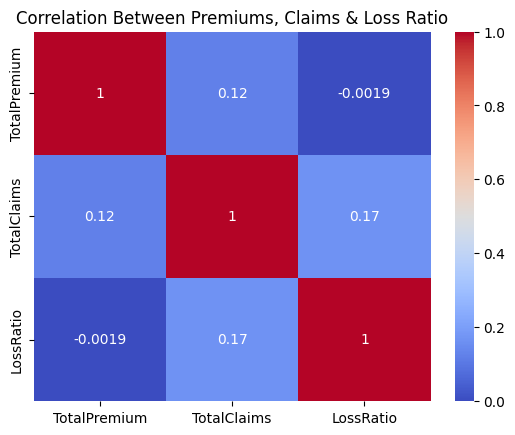

In [15]:
sns.heatmap(clean[['TotalPremium', 'TotalClaims', 'LossRatio']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Premiums, Claims & Loss Ratio")
plt.show()

✅ **Scatter plot of `TotalPremium` vs. `TotalClaims`** (with Province coloring):

c:\Users\girma\OneDrive\Desktop\10 Academy\week-3\insurance-risk-modeling\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


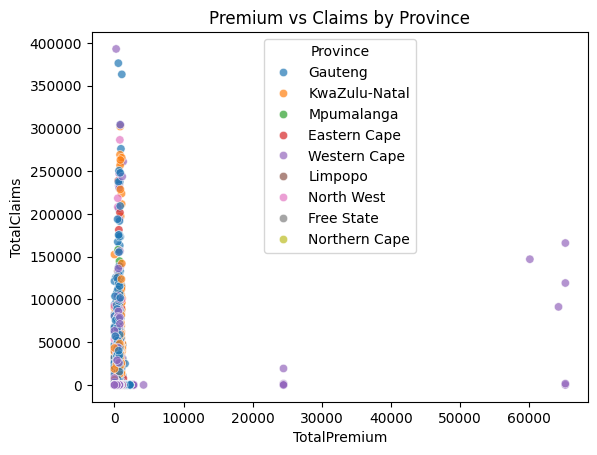

In [16]:
sns.scatterplot(data=clean, x='TotalPremium', y='TotalClaims', hue='Province', alpha=0.7)
plt.title("Premium vs Claims by Province")
plt.show()

### **4️⃣ Geographic & Trend-Based Comparisons**
✅ **Loss Ratio by Province**:

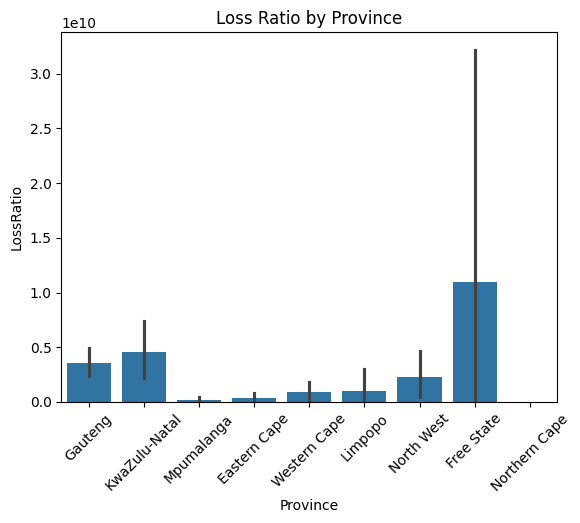

In [17]:
sns.barplot(x='Province', y='LossRatio', data=clean)
plt.xticks(rotation=45)
plt.title('Loss Ratio by Province')
plt.show()

✅ **Claim Trends Over Time**:

<Axes: title={'center': 'Total Claims Over Time'}, xlabel='TransactionMonth'>

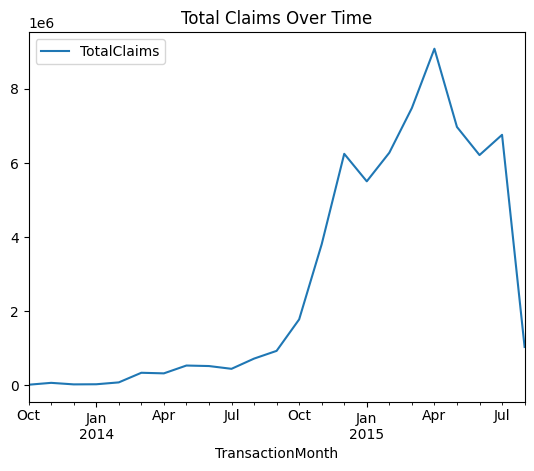

In [18]:
monthly_trends = clean.groupby(clean['TransactionMonth'].dt.to_period('M')).agg({'TotalClaims': 'sum'})
monthly_trends.plot(kind='line', title='Total Claims Over Time')

### **5️⃣ Outlier Detection**
✅ **Box plots for financial features**:

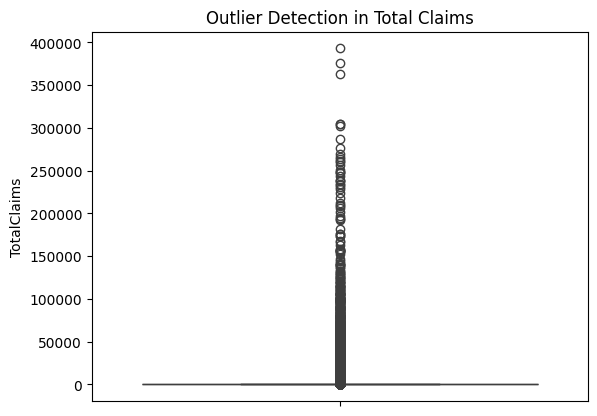

In [19]:
sns.boxplot(y='TotalClaims', data=clean)
plt.title('Outlier Detection in Total Claims')
plt.show()

### **6️⃣ Final Visualization Deliverables**
We’ll generate **3 insightful plots** to wrap up:
1. **Loss Ratio by Province (Risk Map)**
2. **Claim Frequency over Time (Temporal Analysis)**
3. **Premium vs Claims (Scatter Plot with Providence grouping)**